In [ ]:
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from sklearn.model_selection import cross_val_score

import pickle

from google.colab import drive


In [ ]:
! pip install -q kaggle

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
pickle_in = open("/content/gdrive/My Drive/Image_Proccessing/X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("/content/gdrive/My Drive/Image_Proccessing/y.pickle","rb")
y = pickle.load(pickle_in)

In [ ]:
pretrained_model = tf.keras.applications.DenseNet201(
            include_top=False ,
            weights='imagenet', #tuning10 weights='noisy-student' instead of 'imagenet'
                                #Self-training with Noisy Student improves ImageNet classification https://arxiv.org/abs/1911.04252) 
            #pooling='avg', #tuning1
            input_shape=[224,224, 3]
        )

pretrained_model.trainable = True #tuning8 pretrained_model.trainable = True

model = tf.keras.Sequential([
            pretrained_model, #Base pretrained on ImageNet to extract features from images

            tf.keras.layers.GlobalAveragePooling2D(), ##Attach a new head to act as a classifier
            #tf.keras.layers.Dropout(0.3), #tuning3
            tf.keras.layers.Dense(14, activation='softmax')
        ])

In [ ]:
model.compile(optimizer='adam'
,loss='sparse_categorical_crossentropy'
,metrics=['sparse_categorical_accuracy'],
)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_3   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 14)                26894     
                                                                 
Total params: 18,348,878
Trainable params: 18,119,822
Non-trainable params: 229,056
_________________________________________________________________


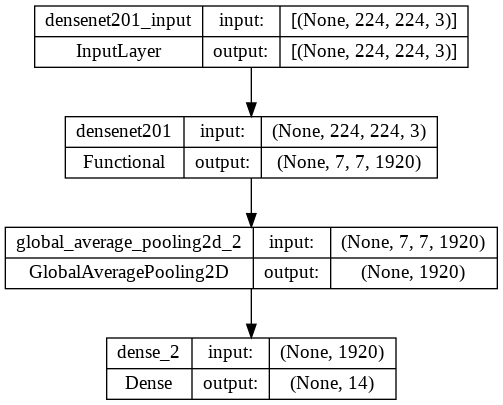

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
X=X/224

In [ ]:
history = model.fit(
        X,np.array(y),
        # validation_split=0.3,
        epochs=3,
        batch_size=10,
        # callbacks=[lr_callback, checkpoint], # Model weights are saved at the end of every epoch, if it's the best seen so far
        #workers = 3 #tuning5 https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras
        # class_weight = weight_per_class #tuning11
    )

Epoch 1/3
6/6 [==============================] - 20s 190ms/step - loss: 2.5722 - sparse_categorical_accuracy: 0.1695
Epoch 2/3
6/6 [==============================] - 1s 188ms/step - loss: 0.6193 - sparse_categorical_accuracy: 0.8136
Epoch 3/3
6/6 [==============================] - 1s 188ms/step - loss: 0.1855 - sparse_categorical_accuracy: 0.9492


In [ ]:
!zip -r /content/my_model.zip /content/my_model

	zip warning: name not matched: /content/my_model

zip error: Nothing to do! (try: zip -r /content/my_model.zip . -i /content/my_model)


In [ ]:
frame = pd.DataFrame(history.history)

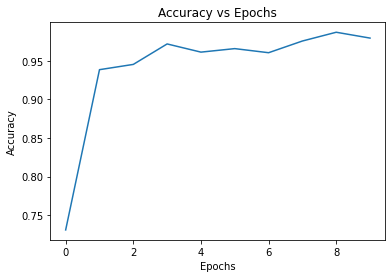

In [ ]:
acc_plot = frame.plot(y="sparse_categorical_accuracy", title="Accuracy vs Epochs", legend=False)
acc_plt = acc_plot.set(xlabel="Epochs", ylabel="Accuracy")

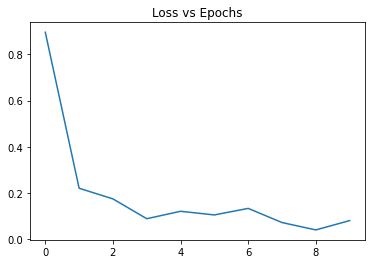

In [ ]:
loss_plot = frame.plot(y="loss", title = "Loss vs Epochs",legend=False)
loss_plt = acc_plot.set(xlabel="Epochs", ylabel="Loss")

In [ ]:
DATADIR = "/content/gdrive/My Drive/Image_Proccessing/14-celebrity-faces-dataset/data/val"

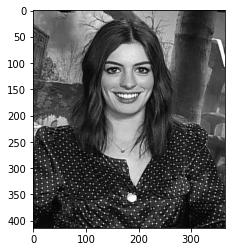

In [ ]:
import cv2
from tqdm import tqdm


# CATEGORIES = [ "anne_hathaway","arnold_schwarzenegger", "ben_afflek", "dwayne_johnson","elton_john","jerry_seinfeld","kate_beckinsale","keanu_reeves"
# ,"lauren_cohan","madonna","mindy_kaling","simon_pegg","sofia_vergara","will_smith"]

CATEGORIES = [ "anne_hathaway","arnold_schwarzenegger", "ben_afflek", "dwayne_johnson","elton_john","jerry_seinfeld","kate_beckinsale","keanu_reeves"
,"lauren_cohan","madonna","mindy_kaling","simon_pegg"]

for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(DATADIR,category)  # create path to dogs and cats
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

In [ ]:
val_data = []

def create_val_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        # path_aug=os.path.join(DATADIR_2,"output")
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                
                # img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                img_array = cv2.imread(os.path.join(path,img) )  # convert to array

                new_array = cv2.resize(img_array, (224, 224))  # resize to normalize data size
                # print(new_array)
                
                # plt.imshow(new_array)
                # plt.show()
                val_data.append([new_array, class_num])  # add this to our training_data

                
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))
        # print(path_aug)
        
        # for img in tqdm(os.listdir(path_aug)):  # iterate over each image per dogs and cats
        #     try:
        #         print(img)
        #         # img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        #         img_array = cv2.imread(os.path.join(path,img) )  # convert to array
        #         print("####",img_array)
        #         new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                
                
        #         plt.imshow(new_array)
        #         plt.show()
        #         training_data.append([new_array, class_num])  # add this to our training_data

                
        #     except Exception as e:  # in the interest in keeping the output clean...
        #         pass
        # #     #except OSError as e:
        # #     #    print("OSErrroBad img most likely", e, os.path.join(path,img))
        # #     #except Exception as e:
        # #     #    print("general exception", e, os.path.join(path,img))


create_val_data()

print(len(val_data))

100%|██████████| 5/5 [00:00<00:00, 135.08it/s]

59


In [ ]:
X = []
y = []

for features,label in val_data:
    X.append(features)
    y.append(label)


# X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X = np.array(X).reshape(-1, 224, 224, 3)


In [ ]:
test_loss, test_accuracy = model.evaluate(X,np.array(y))

2/2 [==============================] - 0s 129ms/step - loss: 12.3802 - sparse_categorical_accuracy: 0.0847


In [ ]:
print(test_loss)
print(test_accuracy)

4.337172508239746
0.10169491171836853
